### My assumptions:



1.   All states are initialized to 0
2.   Measurements are independent
3.   Covariance of inputs is an identity matrix
4.   Initial covariance of state is an identity matrix
5.   Horizontal and vertical motions are decoupled




#### Imports and mount data

In [ ]:
import csv
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os.path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the data. This is a modified version of the code stubs with different headers

In [ ]:
def load_data(filename):
    """Load data from the csv log

    Parameters:
    filename (str)  -- the name of the csv log

    Returns:
    data (dict)     -- the logged data with data categories as keys
                       and values list of floats
    """
    #Open the file
    f = open(filename)

    file_reader = csv.reader(f, delimiter=',')

    # Load data into dictionary with headers as keys
    data = {}
    header = ["t", "Uv", "Ul", "Ur", "x", "y", "z", "yaw"]
    for h in header:
        data[h] = []

    row_num = 0
    f_log = open("bad_data_log.txt", "w")
    for row in file_reader:
        for h, element in zip(header, row):
            # If got a bad value just use the previous value
            try:
                data[h].append(float(element))
            except ValueError:
                data[h].append(data[h][-1])
                f_log.write(str(row_num) + "\n")

        row_num += 1
    f.close()
    f_log.close()

    return data

In [ ]:
datapath = "Blimp_data.csv"
data = load_data(datapath)

## To get an idea of the blimp path, plot the path in 3d!

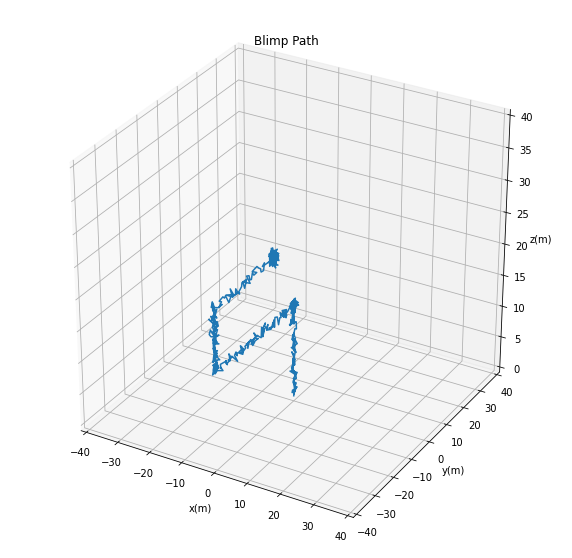

In [ ]:
#This only works with the mplot3d package. If it isn't installed, you can still visualize the path
#With the 2d Plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

#Make a 3d axis
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title('Blimp Path')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')



#Plot the GPS data
ax.set_xlim(-40, 40); ax.set_ylim(-40, 40); ax.set_zlim(0, 40);
ax.plot3D(data['x'], data['y'], data['z'])

#### 2d plots of GPS for alternative visualization

Text(0, 0.5, 'Alttude[m]')

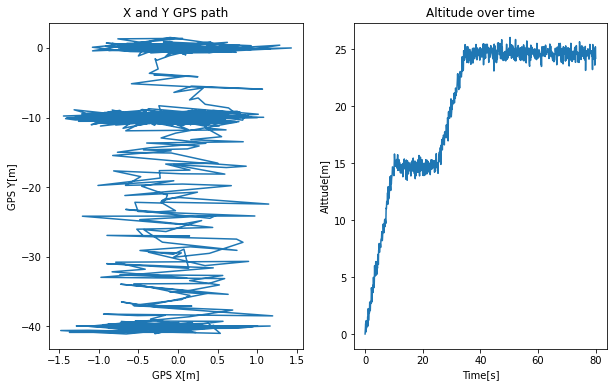

In [ ]:
#Plot the 2d gps and altitude plots for visualizing path
f, (ax1, ax2) = plt.subplots(1, 2, figsize =(10,6))
ax1.plot(data['x'], data['y'])
ax1.set_title('X and Y GPS path')
ax1.set_xlabel('GPS X[m]')
ax1.set_ylabel('GPS Y[m]')
ax2.plot(data['t'], data['z'])
ax2.set_title('Altitude over time')
ax2.set_xlabel('Time[s]')
ax2.set_ylabel('Alttude[m]')

Looking at these plots, we see the following for the blimp path:

First, the blimp flies upward to around 15m over 10 seconds. Second, it moves around 40m south over 10 seconds. Third, it flies upward to around 25m over 10 seconds. Finally, it flies northward about 30m to a final point of (x,y,z) = (0,-10,25) over 5 seconds. It stays there for the remainder of the time(40 seconds).

## Determining the measurement variance

#### We also need to find variance from nonchanging measurements. From the csv, things don't seem to change after point 400(40s onward). We can plot those points to verify the blimp is stationary.

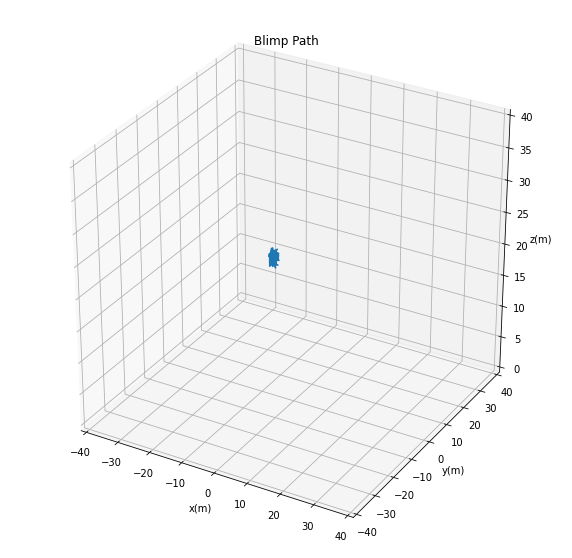

In [ ]:
#Split off the points after 400 where it seems to be stationary
small_x = data['x'][400:]
small_y = data['y'][400:]
small_z = data['z'][400:]
small_theta = data['yaw'][400:]

#Plot the points in 3d. THIS WILL ALSO BREAK WITHOUT THE 3d MATPLOTLIB LIBRARIES
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title('Blimp Path')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')


ax.set_xlim(-40, 40); ax.set_ylim(-40, 40); ax.set_zlim(0, 40);
ax.plot3D(small_x, small_y, small_z)

#### We can see that it is stationary. We can therefore use these points to find our covariance matrix sigma_z,t

In [ ]:
#Make a matrix of the stationary points
still_data = np.vstack((small_x, small_y, small_z, small_theta))
#Find covariance
sigma_z_t = np.cov(still_data)
#Print it out
print(sigma_z_t)

[[ 2.33846123e-01 -5.59011401e-03  4.68394222e-03 -1.63594142e-04]
 [-5.59011401e-03  2.51257069e-01  8.64220125e-04  3.28986889e-05]
 [ 4.68394222e-03  8.64220125e-04  2.30401013e-01 -3.37851660e-05]
 [-1.63594142e-04  3.28986889e-05 -3.37851660e-05  9.04761638e-05]]


## Implement the KF from code stubs. First, define all helper functions

#### In my implementation, I made the assumption that input covariance is an identity matrix

In [ ]:
#Define timestep
DT = 0.1
#Number of variables in the state
#My state is x,y,z,xdot,ydot,zdot,theta
N = 7
#Number of measured variables: x,y,z,theta
M = 4
#Number of inputs: ul,ur,uz
S = 3
def wrap_to_pi(angle):
    """Wrap angle data in radians to [-pi, pi]

    Parameters:
    angle (float)   -- unwrapped angle

    Returns:
    angle (float)   -- wrapped angle
    """
    while angle >= math.pi:
        angle -= 2*math.pi

    while angle <= -math.pi:
        angle += 2*math.pi
    return angle


def propogate_state(x_t_prev, u_t):
    """Propogate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate
    u_t (np.array)       -- the current control input

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """
    
    #Propagate through the system dynamics. 
    #The first 3 states(x,y,z) are all just incremented by the 4th,5th, and 6th states (xdot,ydot,zdot) times DT
    x_bar_t = np.array([x_t_prev[0] + DT * x_t_prev[3],
                        x_t_prev[1] + DT * x_t_prev[4],
                        x_t_prev[2] + DT * x_t_prev[5], 
    #xdot,ydot,zdot, and thetadot are changed according to the relationship between input thrusts and velocities
    #xdot and ydot are also converted to global frame using theta
                        1*(u_t[0]+u_t[1])*np.cos(x_t_prev[6]),
                        1*(u_t[0]+u_t[1])*np.sin(x_t_prev[6]),
                        0.5*u_t[2],
                        x_t_prev[6] + 0.315*(-u_t[0] + u_t[1])])
    
    x_bar_t[6] = wrap_to_pi(x_bar_t[6])
    return x_bar_t


def calc_prop_jacobian_x(x_t_prev, u_t):
    """Calculate the Jacobian of your motion model with respect to state

    Parameters:
    x_t_prev (np.array) -- the previous state estimate
    u_t (np.array)      -- the current control input

    Returns:
    G_x_t (np.array)    -- Jacobian of motion model wrt to x
    """
    #Set up the Jacobian
    G_x_t = np.zeros((N,N))
    #Change elements where necessary. This is found by taking derivatives of system dynamics w.r.t state variables
    G_x_t[0][0] = 1
    G_x_t[1][1] = 1
    G_x_t[2][2] = 1
    G_x_t[6][6] = 1
    G_x_t[0][3] = DT
    G_x_t[3][6] = -math.sin(x_t_prev[6])*(u_t[0]+u_t[1])
    G_x_t[4][6] = math.cos(x_t_prev[6])*(u_t[0]+u_t[1])
    G_x_t[1][4] = DT
    G_x_t[2][5] = DT

    return G_x_t


def calc_prop_jacobian_u(x_t_prev, u_t):
    """Calculate the Jacobian of motion model with respect to control input

    Parameters:
    x_t_prev (np.array)     -- the previous state estimate
    u_t (np.array)          -- the current control input

    Returns:
    G_u_t (np.array)        -- Jacobian of motion model wrt to u
    """
    #Set up Jacobian
    G_u_t = np.zeros((N,S))
    #Change elements where necessary. This is found by taking derivatives of system dynamics w.r.t inputs
    G_u_t[3][0] = math.cos(x_t_prev[6])
    G_u_t[3][1] = math.cos(x_t_prev[6])
    G_u_t[4][0] = math.sin(x_t_prev[6])
    G_u_t[4][1] = math.sin(x_t_prev[6])
    G_u_t[5][2] = 0.5
    G_u_t[6][0] = -0.315*DT
    G_u_t[6][1] = 0.315*DT

    return G_u_t


def prediction_step(x_t_prev, u_t, sigma_x_t_prev):
    """Compute the prediction of EKF

    Parameters:
    x_t_prev (np.array)         -- the previous state estimate
    u_t (np.array)              -- the control input
    sigma_x_t_prev (np.array)   -- the previous variance estimate

    Returns:
    x_bar_t (np.array)          -- the predicted state estimate of time t
    sigma_x_bar_t (np.array)    -- the predicted variance estimate of time t
    """

   # Covariance matrix of control input. I assume that the covariance of inputs is identity
    sigma_u_t = np.identity(S)

    #Propagate the state
    x_bar_t = propogate_state(x_t_prev, u_t)

    #Calculate jacobians
    G_xt = calc_prop_jacobian_x(x_t_prev, u_t)
    G_ut = calc_prop_jacobian_u(x_t_prev, u_t)


    #Find new covariance with the Jacobians

    sigma_x_bar_t = (G_xt@sigma_x_t_prev)@ G_xt.T + (G_ut@sigma_u_t)@ G_ut.T
 
    return [x_bar_t, sigma_x_bar_t]


def calc_meas_jacobian(x_bar_t):
    """Calculate the Jacobian of your measurment model with respect to state

    Parameters:
    x_bar_t (np.array)  -- the predicted state

    Returns:
    H_t (np.array)      -- Jacobian of measurment model
    """
    #Initialize H_t
    H_t = np.zeros((M,N))
    #Since the state is in global frame and measurements are in global frame,
    #H_t is trivial. Just take the measured variables from x_bar_t
    H_t[0][0] = 1
    H_t[1][1] = 1
    H_t[2][2] = 1
    H_t[3][6] = 1


    return H_t


def calc_kalman_gain(sigma_x_bar_t, H_t):
    """Calculate the Kalman Gain

    Parameters:
    sigma_x_bar_t (np.array)  -- the predicted state covariance matrix
    H_t (np.array)            -- the measurement Jacobian

    Returns:
    K_t (np.array)            -- Kalman Gain
    """
    # Covariance matrix of measurments. Using Kalman Filter gain equation
    K_t = ((sigma_x_bar_t @ H_t.T) @ np.linalg.inv(((H_t @ sigma_x_bar_t)@ H_t.T) + sigma_z_t))


    return K_t


def calc_meas_prediction(x_bar_t):
    """Calculate predicted measurement based on the predicted state

    Parameters:
    x_bar_t (np.array)  -- the predicted state

    Returns:
    z_bar_t (np.array)  -- the predicted measurement
    """
    #Since everything is global frame, just take the measured variables from state
    z_bar_t = np.array([x_bar_t[0], x_bar_t[1], x_bar_t[2], x_bar_t[6]])

    return z_bar_t


def correction_step(x_bar_t, z_t, sigma_x_bar_t):
    """Compute the correction of EKF

    Parameters:
    x_bar_t       (np.array)    -- the predicted state estimate of time t
    z_t           (np.array)    -- the measured state of time t
    sigma_x_bar_t (np.array)    -- the predicted variance of time t

    Returns:
    x_est_t       (np.array)    -- the filtered state estimate of time t
    sigma_x_est_t (np.array)    -- the filtered variance estimate of time t
    """
    #Get H_t, K_t, h_t from helpers
    H_t = calc_meas_jacobian(x_bar_t)
    K_t = calc_kalman_gain(sigma_x_bar_t, H_t)
    h_t = calc_meas_prediction(x_bar_t)
    I = np.identity(N)

    #Find the difference between measure and preducted
    dif =  (z_t - h_t)

    #Wrap the theta of state
    dif[3] =  wrap_to_pi(dif[3])

    #Find estimates with correction step eqns
    x_est_t = x_bar_t + np.matmul(K_t, dif)
    sigma_x_est_t = np.matmul((I - np.matmul(K_t, H_t)), sigma_x_bar_t)

    return [x_est_t, sigma_x_est_t]


## Main function for running KF

### I made the assumtion that the blimp started at 0 for all state variables with initial covariance as the identity matrix

In [ ]:

#Load data
datapath = "blimp_data.csv"
data = load_data(datapath)

# Load data into variables
Ul = data["Ul"]
Ur = data["Ur"]
Uv = data["Uv"]
x_gps = data["x"]
y_gps = data["y"]
z_alt = data["z"]
theta_compass = data['yaw']
time_stamps = data["t"]


#  Initialize filter.
z_0 = np.array([0,0,0,0,0,0,0])
state_est_t_prev = z_0

#Assume identity for initial cov
var_est_t_prev = np.identity(N)

#Make vars to store estimates
state_estimates = np.empty((N, len(time_stamps)))
covariance_estimates = np.empty((N, N, len(time_stamps)))

#  Run filter over data
for t, _ in enumerate(time_stamps):
    # Get control input
    u_t = np.array([Ul[t], Ur[t], Uv[t]])

    # Prediction Step
    state_pred_t, var_pred_t = prediction_step(state_est_t_prev, u_t, var_est_t_prev)
    # Get measurement
    z_t = np.array([x_gps[t],y_gps[t], z_alt[t], theta_compass[t] ])

    # Correction Step
    state_est_t, var_est_t = correction_step(state_pred_t, z_t, var_pred_t)

    state_est_t_prev = state_est_t
    var_est_t_prev = var_est_t

    # Log Data
    state_estimates[:, t] = state_est_t
    covariance_estimates[:, :, t] = var_est_t




In [ ]:
#Extract the blimp path estimates
x_estimates = state_estimates[0, :]
y_estimates = state_estimates[1,:]
z_estimates = state_estimates[2,:]
theta_estimates = state_estimates[6, :]
theta_variance = []
for x in range(state_estimates.shape[1]):
  cov = covariance_estimates[:,:,x]
  theta_variance.append(cov[6, 6])
  


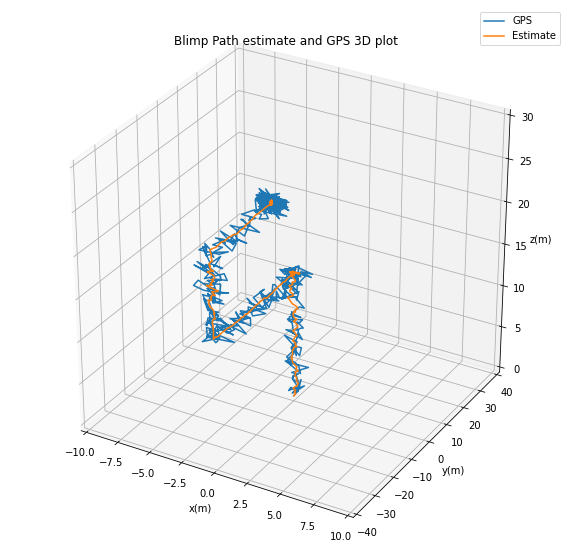

In [ ]:
#Plot the 3d blimp path estimate over GPS
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title('Blimp Path estimate and GPS 3D plot')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')


ax.set_xlim(-10, 10); ax.set_ylim(-40, 40); ax.set_zlim(0, 30);

ax.plot3D(x_gps, y_gps, z_alt, label = 'GPS')
ax.plot3D(x_estimates, y_estimates, z_estimates, label = 'Estimate')
ax.legend()

Text(0, 0.5, 'Y Position [m]')

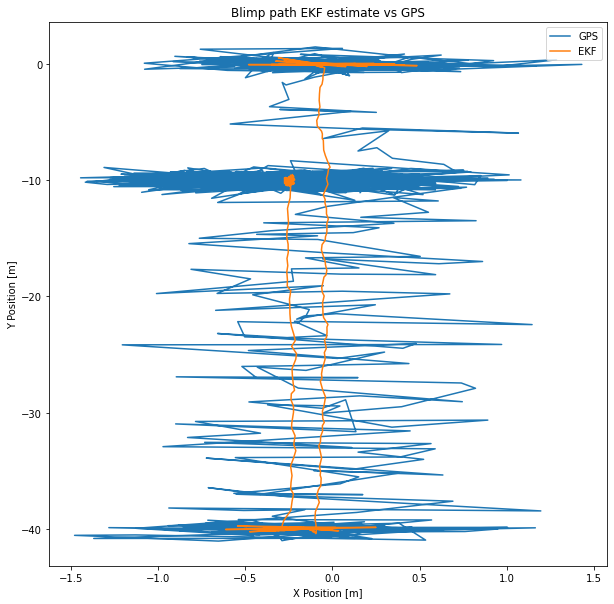

In [ ]:
#First, plot 2d blimp path against EKF estimate
f, (ax) = plt.subplots(1, 1, figsize =(10,10))
ax.plot(x_gps, y_gps, label="GPS")
ax.plot(x_estimates, y_estimates, label="EKF")

ax.legend(loc = 'upper right')
ax.set_title("Blimp path EKF estimate vs GPS")
ax.set_xlabel("X Position [m]")
ax.set_ylabel("Y Position [m]")

Text(0, 0.5, 'Altitude[m]')

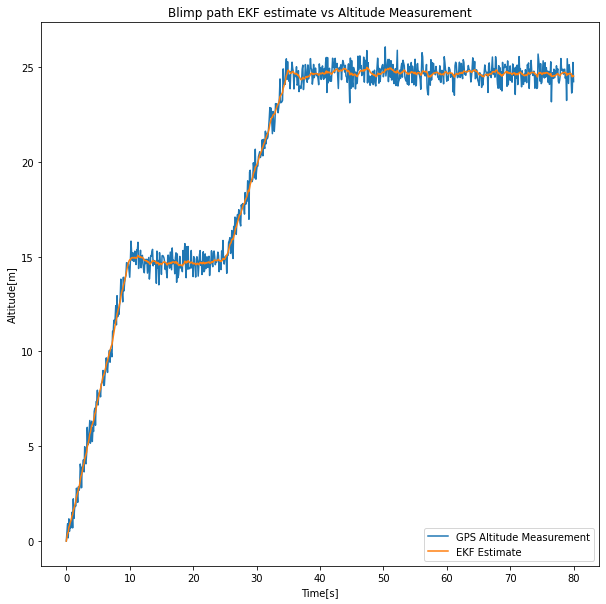

In [ ]:
#Second, plot altitude measurement against EKF estimate
f, (ax) = plt.subplots(1, 1, figsize =(10,10))
ax.plot(time_stamps, z_alt, label="GPS Altitude Measurement")
ax.plot(time_stamps, z_estimates, label="EKF Estimate")

ax.legend(loc = 'lower right')
ax.set_title("Blimp path EKF estimate vs Altitude Measurement")
ax.set_xlabel("Time[s]")
ax.set_ylabel("Altitude[m]")

## This plot skips the first few points. This is the case because I started with my variance high in my assumed state so the correct variances are hard to see if the early ones are included

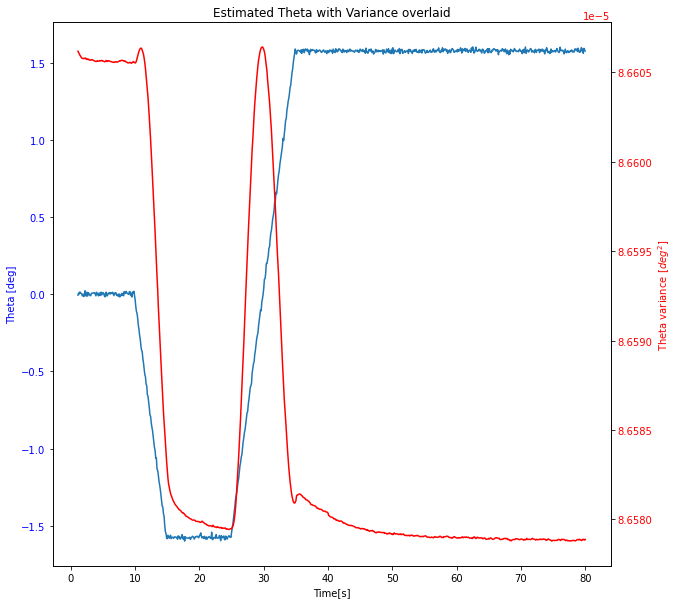

In [ ]:
#Third, plot theta and its standard deviation
f, (ax) = plt.subplots(1, 1, figsize =(10,10))
ax.plot(time_stamps[10:], theta_estimates[10:], label="Theta Estimate")
ax2 = ax.twinx()
ax2.plot(time_stamps[10:], theta_variance[10:], label="Theta Variance", color = 'red')

ax.set_title("Estimated Theta with Variance overlaid")
ax.set_xlabel("Time[s]")
ax.set_ylabel("Theta [deg]", color = 'blue')
ax2.set_ylabel("Theta variance [$deg^2$]", color = 'red')
ax2.tick_params(axis = 'y', labelcolor= 'red')
ax.tick_params(axis = 'y', labelcolor= 'blue')